In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:
# data in
df_first = pd.read_csv("data/etl_gru_month_180601.csv", sep="|", header=None)
#df_first = pd.read_csv("data/etl_sum_bungae_acctit_452104.csv", sep="|")
df_first = df_first.rename(index=str, columns={0:"기업고유번호", 1:"월", 2:"업종코드"})

In [26]:
y_2 = []
for p in range(len(df_first)//10):    # 각 기업의 데이터는 10월 단위로 존재
    for q in range(9):    # 0~9
        y_2.append(df_first[26][p*10 +q +1])  # 26번째 값을 임의의 월단위로 추출
y_5 = []
for p in range(len(df_first)//10):
    for q in range(5):
        y_5.append(df_first[26][p*10 +q +4])  # 

KeyError: 26

In [4]:
print("기업수: {}".format(len(df_first)//20))

기업수: 13554


In [5]:
df_second = df_first.loc[df_first["월"] != 10]  # 1~9월
df_fifth = df_first.loc[df_first["월"] < 6]  # 1~5월
ID = df_first["기업고유번호"]

In [6]:
df_second["y2"] = y_2
df_fifth["y5"] = y_5
df_second = df_second.drop(26, axis=1)
df_fifth = df_fifth.drop(26, axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
df_first = df_first[df_first["업종코드"] == 452104.0]
df_second = df_second[df_second["업종코드"] == 452104.0]
df_fifth = df_fifth[df_fifth["업종코드"] == 452104.0]

In [8]:
# ZERO COUNT
cols = df_first.columns
for col in cols:
    a = df_first[col].tolist().count(0)
    print("Number of zeros in {}: {}%".format(col, int(a/len(df_first)*100)))

Number of zeros in 기업고유번호: 0%
Number of zeros in 월: 0%
Number of zeros in 업종코드: 0%
Number of zeros in 3: 1%
Number of zeros in 4: 66%
Number of zeros in 5: 6%
Number of zeros in 6: 33%
Number of zeros in 7: 0%
Number of zeros in 8: 12%
Number of zeros in 9: 26%
Number of zeros in 10: 0%
Number of zeros in 11: 15%
Number of zeros in 12: 38%
Number of zeros in 13: 1%
Number of zeros in 14: 81%
Number of zeros in 15: 8%
Number of zeros in 16: 10%
Number of zeros in 17: 95%
Number of zeros in 18: 22%
Number of zeros in 19: 10%
Number of zeros in 20: 6%
Number of zeros in 21: 67%
Number of zeros in 22: 95%
Number of zeros in 23: 8%
Number of zeros in 24: 26%
Number of zeros in 25: 26%
Number of zeros in 26: 0%


In [9]:
df_first = df_first.rename(index=str, columns={8:"매출", 26:"매출증가량"})
df_second = df_second.rename(index=str, columns={8:"매출", "y2":"매출증가량"})
df_fifth = df_fifth.rename(index=str, columns={8:"매출", "y5":"매출증가량"})

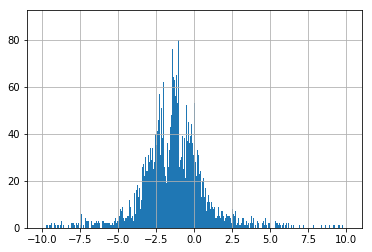

In [10]:
%matplotlib inline
df_second["매출증가량"].hist(bins=1000, range=(-10, 10))

In [11]:
y_first = df_first["매출증가량"]
df_first = df_first.drop("매출증가량", axis=1)
y_second = df_second["매출증가량"]
df_second = df_second.drop("매출증가량", axis=1)
y_fifth = df_fifth["매출증가량"]
df_fifth = df_fifth.drop("매출증가량", axis=1)

In [12]:
# 고유번호, 월, 업종코드 제거
df_first = df_first.drop(["기업고유번호", "월", "업종코드"], axis=1)
df_second = df_second.drop(["기업고유번호", "월", "업종코드"], axis=1)
df_fifth = df_fifth.drop(["기업고유번호", "월", "업종코드"], axis=1)

## Feature generation
- 기존 : val_loss 0.6
- generation : $x^2, \sqrt x$

In [13]:
data1_square = df_first ** 2
data1_sqrt = np.sqrt(df_first - df_first.min().min()) - np.sqrt(-df_first.min().min())

data2_square = df_second ** 2
data2_sqrt = np.sqrt(df_second - df_second.min().min()) - np.sqrt(-df_second.min().min())

data5_square = df_fifth ** 2
data5_sqrt = np.sqrt(df_fifth - df_fifth.min().min()) - np.sqrt(-df_fifth.min().min())

In [14]:
df_first = pd.concat([df_first, pd.DataFrame(data1_square), pd.DataFrame(data1_sqrt)], axis=1)
df_second = pd.concat([df_second, pd.DataFrame(data2_square), pd.DataFrame(data2_sqrt)], axis=1)
df_fifth = pd.concat([df_fifth, pd.DataFrame(data5_square), pd.DataFrame(data5_sqrt)], axis=1)

In [15]:
scaler = StandardScaler()
df_first = scaler.fit_transform(df_first)
df_second = scaler.fit_transform(df_second)
df_fifth = scaler.fit_transform(df_fifth)

In [16]:
X_first, X_second, X_fifth = [], [], []
y_, y__, y___ = [], [], []
for p in range(len(df_first)//10):
    X_first.append(df_first[10*p : 10*p+10])
    y_.append(y_first[10*p : 10*p+10])
for p in range(len(df_second)//9):
    X_second.append(df_second[9*p : 9*p+9])
    y__.append(y_second[9*p : 9*p+9])
for p in range(len(df_fifth)//5):
    X_fifth.append(df_fifth[5*p : 5*p+5])
    y___.append(y_fifth[5*p : 5*p+5])

## 5월 뒤 예측

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Available device: {}".format(torch.cuda.device_count()))
print("Current CUDA device: {}".format(torch.cuda.current_device()))

torch.cuda.set_device(0)
#with torch.cuda.device(1):
#    print("Inside device is 1")


Available device: 1
Current CUDA device: 0


In [22]:
def batch(tensor, batch_size):
    tensor_list = []
    length = tensor.shape[0]
    i = 0
    while True:
        if (i+1) * batch_size >= length:
            tensor_list.append(tensor[i*batch_size : length])
            return tensor_list
        tensor_list.append(tensor[i*batch_size : (i+1)*batch_size])
        i += 1

class Estimator(object):
    def __init__(self, model):
        self.model = model
    
    def compile(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss_f = loss
    
    def _fit(self, X_list, y_list, month):
        # train one eopch
        loss_list = []
        acc_list = []
        for X, y in zip(X_list, y_list):
            ### CUDA
            #X_v = Variable(torch.FloatTensor(X))
            #y_v = Variable(torch.FloatTensor(y), requires_grad=False)
            
            X_v = Variable(X)
            y_v = Variable(y, requires_grad=False)
            
            self.optimizer.zero_grad()
            y_pred = self.model(X_v, self.model.initHidden(X_v.size()[0]))
            
            # 달 예측
            y_pred = y_pred.reshape(y_pred.shape[0], month)
            
            
            loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))]) / len(y_v)
            
            loss.backward()
            self.optimizer.step()
            
            # for log
            loss_list.append(loss.data[0])
        return sum(loss_list) / len(loss_list)
    
    def fit(self, X, y, batch_size, month, nb_epoch, validation_data=()):
        X_list = batch(X, batch_size)
        y_list = batch(y, batch_size)
        
        train_losses = []
        val_losses = []
        for t in range(1, nb_epoch+1):
            loss = self._fit(X_list, y_list, month)
            val_log = ''
            if validation_data:
                val_loss = self.evaluate(validation_data[0], 
                                         validation_data[1], 
                                         month=month, 
                                         batch_size=batch_size)
                val_log = "- val_loss: %06.4f" % (val_loss)
            print("Epoch %s/%s loss: %06.4f  %s" % (t, nb_epoch, loss, val_log))
            train_losses.append(loss)
            val_losses.append(val_loss)
        return train_losses, val_losses
    
    def evaluate(self, X, y, batch_size, month):
        y_pred = self.predict(X)
        
        # 달 예측
        y_pred = y_pred.reshape(y_pred.shape[0], month)
        
        ### CUDA
        #y_v = Variable(torch.from_numpy(y).float(), requires_grad=False)
        y_v = Variable(y, requires_grad=False)
        loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))]) / len(y_v)
        return loss.data[0]

    def predict(self, X):
        ### CUDA
        #X = Variable(torch.cuda.FloatTensor(X)).cuda()
        X = Variable(X)
        y_pred = self.model(X, self.model.initHidden(X.size()[0]))
        return y_pred
    
    def predict_classes(self, X):
        return torch.topk(self.predict(X), 1)[1].data.numpy().flatten()

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(GRU, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=0.3, num_layers=1)
        self.act = nn.PReLU()
        self.normalization = nn.LayerNorm(hidden_size)
        
        self.linear2 = nn.Linear(hidden_size2, output_size)
        self.linear = nn.Linear(hidden_size, hidden_size2)
    
    def forward(self, input, hidden):
        out1, hn = self.gru(input, hidden)
        out2 = self.normalization(out1)
        out3 = self.act(self.linear(out2))
        out4 = self.linear2(out3)
        return out4
    
    def initHidden(self, N):
        return Variable(torch.randn(1, N, self.hidden_size).cuda())

In [24]:
# STARTING POINT of 5 month
input_size = 69
hidden_size = 32
hidden_size2 = 16
output_size = 1
epochs = 200
batch_size = 32
month = 5

#X_train, X_test, y_train, y_test = train_test_split(X_first, y_, test_size=0.3, random_state=42)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_second, y__, test_size=0.3, random_state=42)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_fifth, y___, test_size=0.3, random_state=42)

print(X_train5)

#X_train5, X_test5, y_train5, y_test5 = np.array(X_train5), np.array(X_test5), np.array(y_train5), np.array(y_test5)
X_train5 = torch.from_numpy(np.array(X_train5)).cuda().type(torch.cuda.FloatTensor)
X_test5 = torch.from_numpy(np.array(X_test5)).cuda().type(torch.cuda.FloatTensor)
y_train5 = torch.from_numpy(np.array(y_train5)).cuda().type(torch.cuda.FloatTensor)
y_test5 = torch.from_numpy(np.array(y_test5)).cuda().type(torch.cuda.FloatTensor)

model = GRU(input_size, hidden_size, hidden_size2, output_size).cuda()

reg = Estimator(model)
reg.compile(optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), loss=nn.L1Loss())

"""
train_losses, val_losses = reg.fit(np.array(X_train5), 
                                   np.array(y_train5), 
                                   month=month, 
                                   batch_size=batch_size, 
                                   nb_epoch=epochs,
                                   validation_data=(np.array(X_test5), np.array(y_test5)))
score = reg.evaluate(np.array(X_test5), 
                     np.array(y_test5), 
                     batch_size=batch_size, 
                     month=month)
prediction5 = reg.predict(X_test5).reshape(np.array(y_test5).shape)
"""
train_losses, val_losses = reg.fit(X_train5, 
                                   y_train5, 
                                   month=month, 
                                   batch_size=batch_size, 
                                   nb_epoch=epochs,
                                   validation_data=(X_test5, y_test5))
score = reg.evaluate(X_test5, 
                     y_test5, 
                     batch_size=batch_size, 
                     month=month)
prediction5 = reg.predict(X_test5).reshape(y_test5.shape)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:78: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert

Epoch 2/200 loss: 5.2699  - val_loss: 3.7738
Epoch 3/200 loss: 5.1157  - val_loss: 3.6994
Epoch 4/200 loss: 5.0313  - val_loss: 3.6243
Epoch 5/200 loss: 4.9570  - val_loss: 3.5707
Epoch 6/200 loss: 4.8904  - val_loss: 3.5214
Epoch 7/200 loss: 4.8252  - val_loss: 3.4486
Epoch 8/200 loss: 4.7376  - val_loss: 3.3585
Epoch 9/200 loss: 4.6600  - val_loss: 3.2927
Epoch 10/200 loss: 4.5961  - val_loss: 3.2360
Epoch 11/200 loss: 4.5668  - val_loss: 3.2226
Epoch 12/200 loss: 4.5520  - val_loss: 3.1866
Epoch 13/200 loss: 4.5302  - val_loss: 3.1717
Epoch 14/200 loss: 4.4983  - val_loss: 3.1643
Epoch 15/200 loss: 4.4911  - val_loss: 3.1462
Epoch 16/200 loss: 4.4825  - val_loss: 3.1422
Epoch 17/200 loss: 4.4709  - val_loss: 3.1331
Epoch 18/200 loss: 4.4646  - val_loss: 3.1216
Epoch 19/200 loss: 4.4471  - val_loss: 3.1116
Epoch 20/200 loss: 4.4490  - val_loss: 3.1147
Epoch 21/200 loss: 4.4383  - val_loss: 3.0987
Epoch 22/200 loss: 4.4340  - val_loss: 3.1012
Epoch 23/200 loss: 4.4314  - val_loss: 3.1

Epoch 180/200 loss: 4.2762  - val_loss: 3.0397
Epoch 181/200 loss: 4.2730  - val_loss: 3.0475
Epoch 182/200 loss: 4.2775  - val_loss: 3.0418
Epoch 183/200 loss: 4.2694  - val_loss: 3.0509
Epoch 184/200 loss: 4.2743  - val_loss: 3.0587
Epoch 185/200 loss: 4.2754  - val_loss: 3.0595
Epoch 186/200 loss: 4.2736  - val_loss: 3.0377
Epoch 187/200 loss: 4.2764  - val_loss: 3.0548
Epoch 188/200 loss: 4.2717  - val_loss: 3.0446
Epoch 189/200 loss: 4.2742  - val_loss: 3.0622
Epoch 190/200 loss: 4.2773  - val_loss: 3.0513
Epoch 191/200 loss: 4.2738  - val_loss: 3.0537
Epoch 192/200 loss: 4.2799  - val_loss: 3.0450
Epoch 193/200 loss: 4.2719  - val_loss: 3.0481
Epoch 194/200 loss: 4.2704  - val_loss: 3.0473
Epoch 195/200 loss: 4.2692  - val_loss: 3.0495
Epoch 196/200 loss: 4.2668  - val_loss: 3.0357
Epoch 197/200 loss: 4.2627  - val_loss: 3.0481
Epoch 198/200 loss: 4.2679  - val_loss: 3.0456
Epoch 199/200 loss: 4.2660  - val_loss: 3.0429
Epoch 200/200 loss: 4.2725  - val_loss: 3.0556


In [23]:
# STARTING POINT of 10 month
input_size = 69
hidden_size = 32
hidden_size2 = 16
output_size = 1
epochs = 200
batch_size = 32
month = 10

X_train, X_test, y_train, y_test = train_test_split(X_first, y_, test_size=0.3, random_state=42)

model = GRU(input_size, hidden_size, hidden_size2, output_size)

reg = Estimator(model)
reg.compile(optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), loss=nn.L1Loss())

train_losses, val_losses = reg.fit(np.array(X_train), 
                                   np.array(y_train), 
                                   month=month, 
                                   batch_size=batch_size, 
                                   nb_epoch=epochs,
                                   validation_data=(np.array(X_test), np.array(y_test)))
score = reg.evaluate(np.array(X_test), 
                     np.array(y_test), 
                     batch_size=batch_size, 
                     month=month)
prediction = reg.predict(X_test).reshape(np.array(y_test).shape)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:74: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1/200 loss: 6.3982  - val_loss: 5.8359
Epoch 2/200 loss: 6.3150  - val_loss: 5.7922
Epoch 3/200 loss: 6.2863  - val_loss: 5.7756
Epoch 4/200 loss: 6.2711  - val_loss: 5.7611
Epoch 5/200 loss: 6.2582  - val_loss: 5.7516
Epoch 6/200 loss: 6.2422  - val_loss: 5.7439
Epoch 7/200 loss: 6.2263  - val_loss: 5.7229
Epoch 8/200 loss: 6.1954  - val_loss: 5.6906
Epoch 9/200 loss: 6.1287  - val_loss: 5.5957
Epoch 10/200 loss: 6.0180  - val_loss: 5.4739
Epoch 11/200 loss: 5.9368  - val_loss: 5.4305
Epoch 12/200 loss: 5.8873  - val_loss: 5.3992
Epoch 13/200 loss: 5.8676  - val_loss: 5.3808
Epoch 14/200 loss: 5.8490  - val_loss: 5.3579
Epoch 15/200 loss: 5.8185  - val_loss: 5.3443
Epoch 16/200 loss: 5.7981  - val_loss: 5.3299
Epoch 17/200 loss: 5.7804  - val_loss: 5.3148
Epoch 18/200 loss: 5.7634  - val_loss: 5.3059
Epoch 19/200 loss: 5.7617  - val_loss: 5.3064
Epoch 20/200 loss: 5.7506  - val_loss: 5.2923
Epoch 21/200 loss: 5.7317  - val_loss: 5.2802
Epoch 22/200 loss: 5.7351  - val_loss: 5.26

Epoch 179/200 loss: 5.4231  - val_loss: 5.1357
Epoch 180/200 loss: 5.4279  - val_loss: 5.1610
Epoch 181/200 loss: 5.4123  - val_loss: 5.1534
Epoch 182/200 loss: 5.4139  - val_loss: 5.1401
Epoch 183/200 loss: 5.4126  - val_loss: 5.1403
Epoch 184/200 loss: 5.4076  - val_loss: 5.1454
Epoch 185/200 loss: 5.4040  - val_loss: 5.1521
Epoch 186/200 loss: 5.4171  - val_loss: 5.1475
Epoch 187/200 loss: 5.4103  - val_loss: 5.1494
Epoch 188/200 loss: 5.4126  - val_loss: 5.1490
Epoch 189/200 loss: 5.4051  - val_loss: 5.1558
Epoch 190/200 loss: 5.4047  - val_loss: 5.1492
Epoch 191/200 loss: 5.4032  - val_loss: 5.1366
Epoch 192/200 loss: 5.4082  - val_loss: 5.1510
Epoch 193/200 loss: 5.4022  - val_loss: 5.1438
Epoch 194/200 loss: 5.4017  - val_loss: 5.1421
Epoch 195/200 loss: 5.4106  - val_loss: 5.1471
Epoch 196/200 loss: 5.4005  - val_loss: 5.1311
Epoch 197/200 loss: 5.3936  - val_loss: 5.1421
Epoch 198/200 loss: 5.4059  - val_loss: 5.1469
Epoch 199/200 loss: 5.3880  - val_loss: 5.1453
Epoch 200/200

In [22]:
# STARTING POINT of 9 month
input_size = 69
hidden_size = 32
hidden_size2 = 16
output_size = 1
epochs = 500
batch_size = 32
month = 9

model = GRU(input_size, hidden_size, hidden_size2, output_size)

reg2 = Estimator(model)
reg2.compile(optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), loss=nn.L1Loss())

train_losses, val_losses = reg2.fit(np.array(X_train2), 
                                   np.array(y_train2), 
                                   month=month, 
                                   batch_size=batch_size, 
                                   nb_epoch=epochs,
                                   validation_data=(np.array(X_test2), np.array(y_test2)))
score = reg2.evaluate(np.array(X_test2), 
                      np.array(y_test2), 
                      batch_size=batch_size, 
                      month=month)
prediction2 = reg2.predict(X_test2).reshape(np.array(y_test2).shape)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:74: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1/500 loss: 6.2937  - val_loss: 4.3949
Epoch 2/500 loss: 6.1212  - val_loss: 4.3192
Epoch 3/500 loss: 6.0428  - val_loss: 4.2608
Epoch 4/500 loss: 5.9893  - val_loss: 4.2062
Epoch 5/500 loss: 5.9263  - val_loss: 4.1515
Epoch 6/500 loss: 5.8466  - val_loss: 4.0644
Epoch 7/500 loss: 5.7615  - val_loss: 3.9831
Epoch 8/500 loss: 5.7068  - val_loss: 3.9474
Epoch 9/500 loss: 5.6730  - val_loss: 3.9201
Epoch 10/500 loss: 5.6408  - val_loss: 3.8878
Epoch 11/500 loss: 5.6197  - val_loss: 3.8702
Epoch 12/500 loss: 5.6002  - val_loss: 3.8578
Epoch 13/500 loss: 5.5760  - val_loss: 3.8496
Epoch 14/500 loss: 5.5634  - val_loss: 3.8142
Epoch 15/500 loss: 5.5523  - val_loss: 3.8143
Epoch 16/500 loss: 5.5367  - val_loss: 3.7943
Epoch 17/500 loss: 5.5210  - val_loss: 3.7950
Epoch 18/500 loss: 5.5045  - val_loss: 3.7763
Epoch 19/500 loss: 5.4978  - val_loss: 3.7661
Epoch 20/500 loss: 5.4826  - val_loss: 3.7669
Epoch 21/500 loss: 5.4757  - val_loss: 3.7605
Epoch 22/500 loss: 5.4662  - val_loss: 3.74

Epoch 178/500 loss: 5.2919  - val_loss: 3.7133
Epoch 179/500 loss: 5.2891  - val_loss: 3.7139
Epoch 180/500 loss: 5.2917  - val_loss: 3.7116
Epoch 181/500 loss: 5.2883  - val_loss: 3.7171
Epoch 182/500 loss: 5.2889  - val_loss: 3.7123
Epoch 183/500 loss: 5.2891  - val_loss: 3.7080
Epoch 184/500 loss: 5.2897  - val_loss: 3.7133
Epoch 185/500 loss: 5.2918  - val_loss: 3.7039
Epoch 186/500 loss: 5.2915  - val_loss: 3.7124
Epoch 187/500 loss: 5.2886  - val_loss: 3.7126
Epoch 188/500 loss: 5.2841  - val_loss: 3.7257
Epoch 189/500 loss: 5.2898  - val_loss: 3.7261
Epoch 190/500 loss: 5.2776  - val_loss: 3.7208
Epoch 191/500 loss: 5.2828  - val_loss: 3.7139
Epoch 192/500 loss: 5.2883  - val_loss: 3.7186
Epoch 193/500 loss: 5.2812  - val_loss: 3.7122
Epoch 194/500 loss: 5.2859  - val_loss: 3.7103
Epoch 195/500 loss: 5.2800  - val_loss: 3.7119
Epoch 196/500 loss: 5.2786  - val_loss: 3.7201
Epoch 197/500 loss: 5.2812  - val_loss: 3.7154
Epoch 198/500 loss: 5.2870  - val_loss: 3.7126
Epoch 199/500

Epoch 355/500 loss: 5.2213  - val_loss: 3.7484
Epoch 356/500 loss: 5.2225  - val_loss: 3.7483
Epoch 357/500 loss: 5.2147  - val_loss: 3.7463
Epoch 358/500 loss: 5.2156  - val_loss: 3.7483
Epoch 359/500 loss: 5.2190  - val_loss: 3.7463
Epoch 360/500 loss: 5.2163  - val_loss: 3.7451
Epoch 361/500 loss: 5.2179  - val_loss: 3.7545
Epoch 362/500 loss: 5.2190  - val_loss: 3.7447
Epoch 363/500 loss: 5.2198  - val_loss: 3.7441
Epoch 364/500 loss: 5.2174  - val_loss: 3.7412
Epoch 365/500 loss: 5.2233  - val_loss: 3.7602
Epoch 366/500 loss: 5.2116  - val_loss: 3.7434
Epoch 367/500 loss: 5.2134  - val_loss: 3.7493
Epoch 368/500 loss: 5.2097  - val_loss: 3.7551
Epoch 369/500 loss: 5.2111  - val_loss: 3.7653
Epoch 370/500 loss: 5.2181  - val_loss: 3.7496
Epoch 371/500 loss: 5.2135  - val_loss: 3.7553
Epoch 372/500 loss: 5.2162  - val_loss: 3.7456
Epoch 373/500 loss: 5.2098  - val_loss: 3.7474
Epoch 374/500 loss: 5.2098  - val_loss: 3.7547
Epoch 375/500 loss: 5.2114  - val_loss: 3.7564
Epoch 376/500

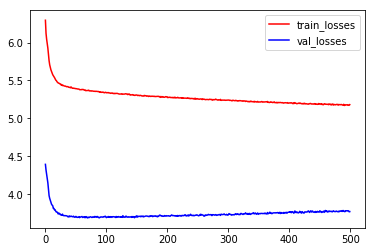

In [23]:
# PLOT
length = len(train_losses)

plt.plot(np.arange(length), train_losses, "r")
plt.plot(np.arange(length), val_losses, "b")
plt.legend(["train_losses", "val_losses"], loc="upper right")
plt.show()

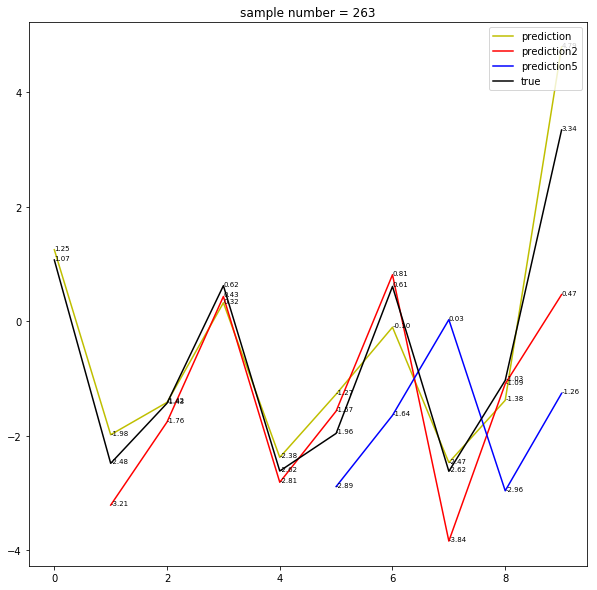

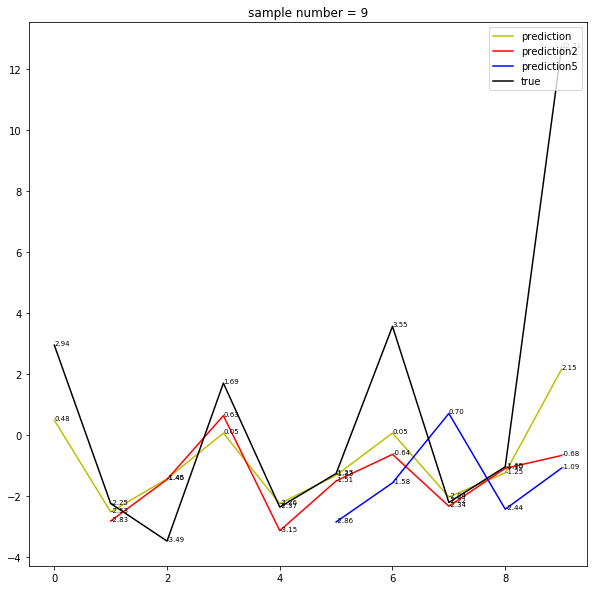

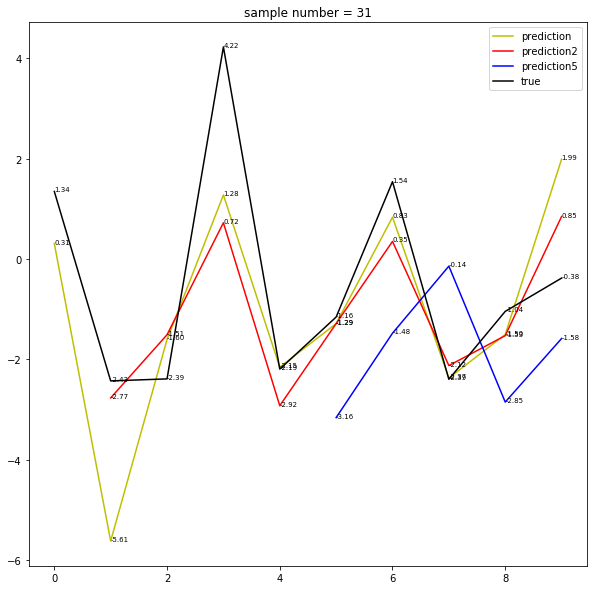

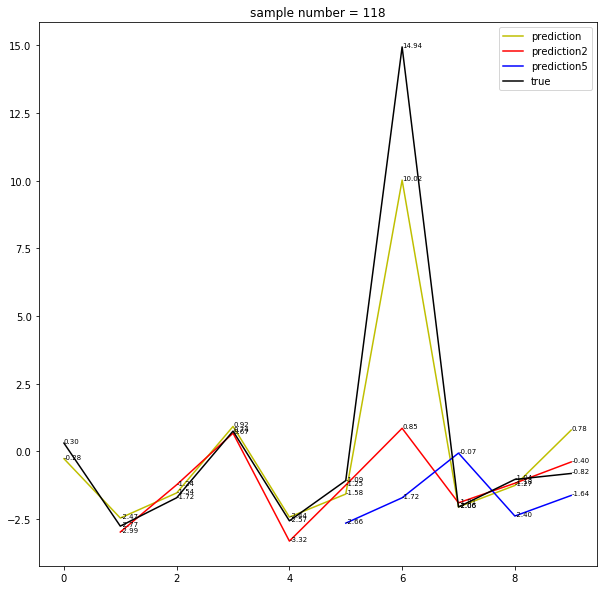

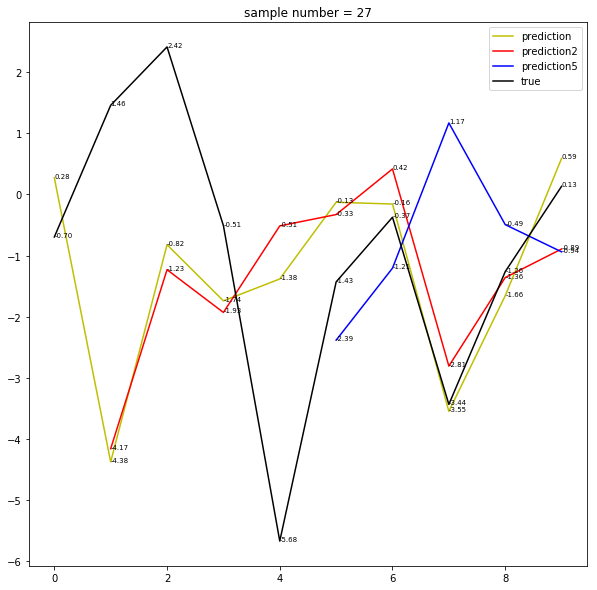

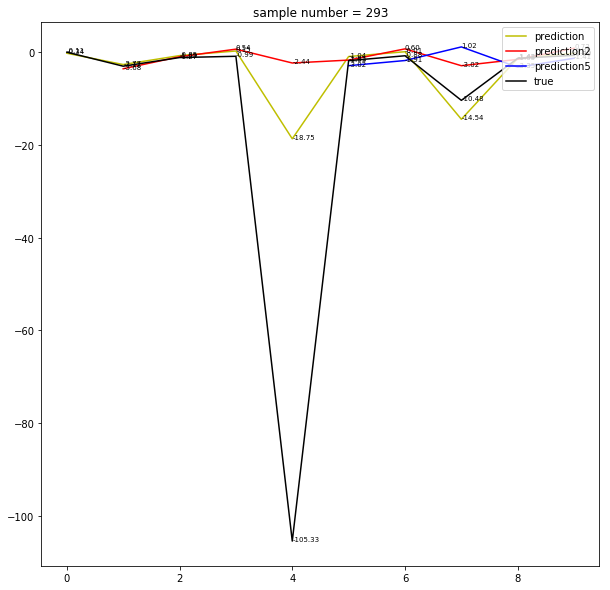

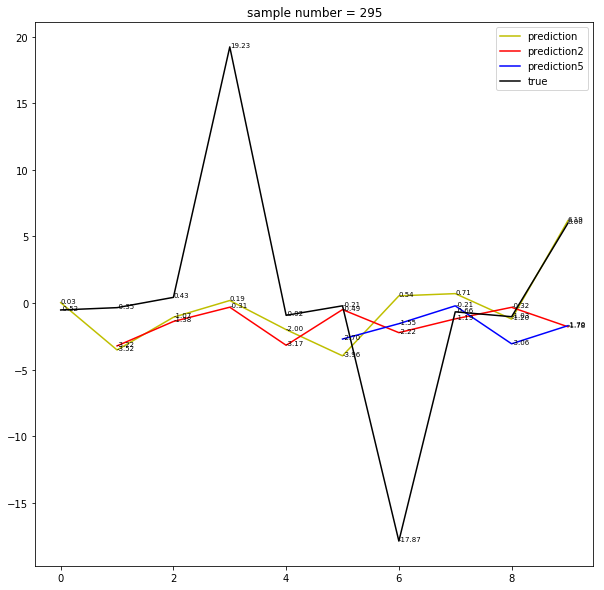

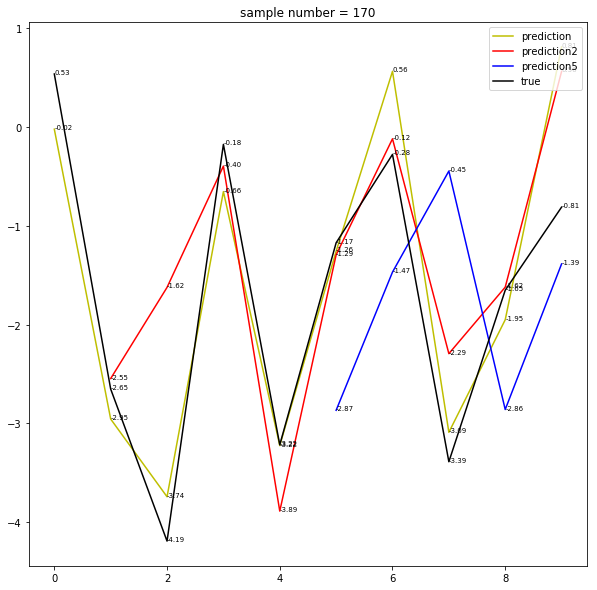

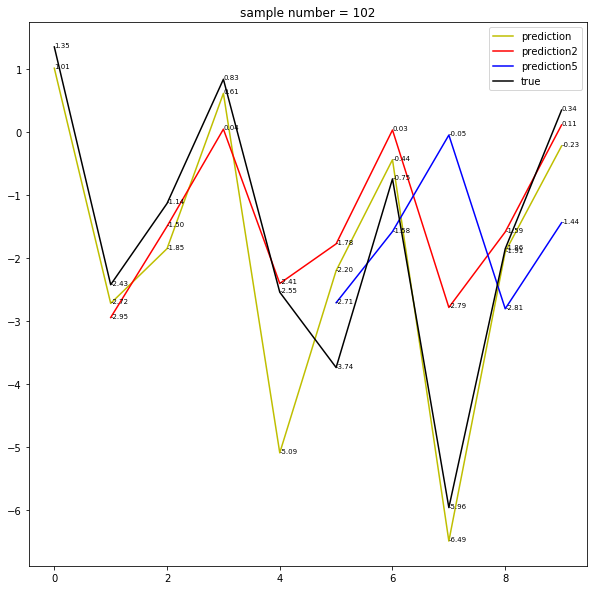

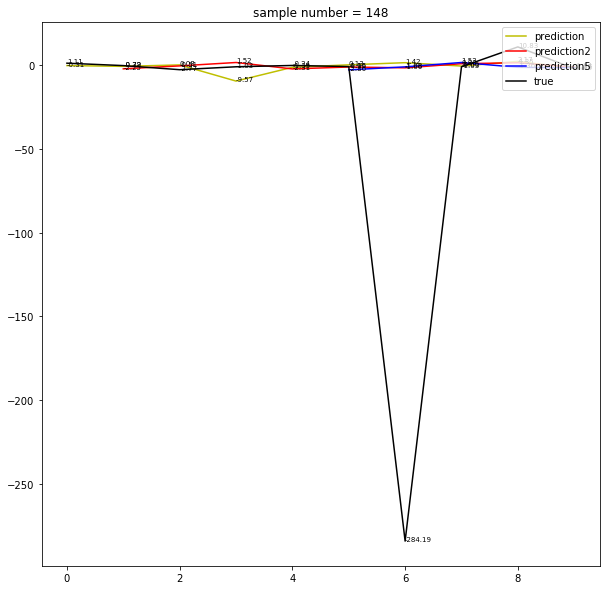

In [24]:
for i in range(10):
    num = np.random.randint(len(y_test))
    x = np.arange(10)
    x_ = np.arange(10)[1:]
    x__ = np.arange(10)[5:]
    plt.figure(figsize=(10,10))
    
    plt.plot(x, prediction[num].detach().numpy(), 'y')
    plt.plot(x_, prediction2[num].detach().numpy(), 'r')
    plt.plot(x__, prediction5[num].detach().numpy(), 'b')
    plt.plot(x, y_test[num].values, 'k')
    
    plt.legend(['prediction', 'prediction2', 'prediction5', 'true'],  loc='upper right')
    plt.title('sample number = {}'.format(num))
    
    for a,b in zip(x, prediction[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x_, prediction2[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x__, prediction5[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x, y_test[num].values): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
    
    plt.show()